# Trying to reproduce the trigger requirements by hand

Two alternatives: 
    - Using RDataFrame (what is used in the usual 2D plots)
    - Using loops (quite slow but more visual)

In [2]:
from analysis_tools import Dataset, Process, Feature
from pprint import pprint
import ROOT
ROOT.ROOT.EnableImplicitMT()


# CONSTANTS
DO_LOOPS = True
xx = 34
yy = 26
zz = 64

zz1 = 64
zz2 = 64

ADD_TO_JETS = 10
MIN_JETS = 1
MAX_JETS = 1
ADD_TO_LEADING_TAU = 18
ADD_TO_SUBLEADING_TAU = 8
ADD_TO_TRIGGER_JETS = 10

Welcome to JupyROOT 6.18/04


In [2]:
# Declare process and dataset objects
ggf_sm_process = Process("ggf_sm", "GGFSM", color=(0, 0, 0))
ggf_bis = Dataset("ggf_sm_bis",
             #"/eos/user/j/jleonhol/HH/ggf_2018_nanotest2/",
             "/eos/user/j/jleonhol/HH/htautau_ggf/",
             ggf_sm_process)

# build RDataFrame and open TFile to obtain the results using both methods
files = ggf_bis.get_files()[0:1]
print files
dataframe_files = ROOT.vector(str)()
for f in files:
    dataframe_files.push_back(f)
df = ROOT.RDataFrame("Events", dataframe_files)


if DO_LOOPS:
    f = ROOT.TChain("Events")
    for file in files:
        f.Add(file)
    #f = ROOT.TFile.Open(files[0])


['/eos/user/j/jleonhol/HH/htautau_ggf//NANO_NANO_1.root']


## RDataFrame

### Previous definitions

In [3]:
# some definitions needed 
def add_to_root(root):
    root.gInterpreter.Declare("""
        using Vfloat = const ROOT::RVec<float>&;      
        ROOT::RVec<ROOT::RVec<float>> lead_sublead(Vfloat pt, Vfloat eta, Vfloat phi, Vfloat mass){
            ROOT::RVec<float> leading_pts = {-1., -1.};
            ROOT::RVec<float> leading_etas = {-1., -1.};
            ROOT::RVec<float> leading_phis = {-1., -1.};
            ROOT::RVec<float> leading_mass = {-1., -1.};
            for (size_t i = 0; i < pt.size(); i++) {
                if (pt[i] > leading_pts[0]){
                    leading_pts[1] = leading_pts[0];
                    leading_etas[1] = leading_etas[0];
                    leading_phis[1] = leading_phis[0];
                    leading_mass[1] = leading_mass[0];
    
                    leading_pts[0] = pt[i];
                    leading_etas[0] = eta[i];
                    leading_phis[0] = phi[i];
                    leading_mass[0] = mass[i];
                } 
                else if (pt[i] > leading_pts[1]){
                    leading_pts[1] = pt[i];
                    leading_etas[1] = eta[i];
                    leading_phis[1] = phi[i];
                    leading_mass[1] = mass[i];
                }
            }
            return ROOT::RVec({leading_pts, leading_etas, leading_phis, leading_mass});
        }
    """)
    
    root.gInterpreter.Declare("""
        Double_t Phi_mpi_pi(Double_t x) {
            while (x >= 3.14159) x -= (2 * 3.14159);
            while (x < -3.14159) x += (2 * 3.14159);
            return x;
        }
    """)

    root.gInterpreter.Declare("""
        #include "TMath.h"
        using Vfloat = const ROOT::RVec<float>&;      
        ROOT::RVec<bool> maskDeltaR(Vfloat eta1, Vfloat phi1, Vfloat eta2, Vfloat phi2, float th_dr) {
            ROOT::RVec<bool> mask;
            for (size_t i = 0; i < eta1.size(); i++){
                bool bigger_deltar = true;
                for (size_t j = 0; j < eta2.size(); j++){
                    Double_t deta = eta1[i] - eta2[j];
                    Double_t dphi = Phi_mpi_pi(phi1[i] - phi2[j]);
                    Double_t dr = TMath::Sqrt(deta * deta + dphi * dphi);
                    if (dr < th_dr) bigger_deltar = false;
                }
                mask.push_back(bigger_deltar);
            }
            return mask;
        }
    """)
    return root
ROOT = add_to_root(ROOT)

In [4]:
df = df.Define("lead_sublead_goodtau_pt",
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[0]").Define("lead_sublead_goodtau_eta", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[1]").Define("lead_sublead_goodtau_phi", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[2]").Define("lead_sublead_goodtau_mass", 
    "lead_sublead("
        "Tau_pt[abs(Tau_eta) <= 2.1], "
        "Tau_eta[abs(Tau_eta) <= 2.1], "
        "Tau_phi[abs(Tau_eta) <= 2.1], "
        "Tau_mass[abs(Tau_eta) <= 2.1]"
    ")[3]")

In [5]:
df = df.Define("lead_sublead_goodl1tau_pt",
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1]"
    ")[0]").Define("lead_sublead_goodl1tau_eta", 
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 2.1]"
    ")[1]").Define("lead_sublead_goodl1tau_phi", 
    "lead_sublead("
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_eta[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_phi[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7], "
        "L1Obj_pt[L1Obj_type == 1 && L1Obj_iso == 1 && abs(L1Obj_eta) <= 4.7]"
    ")[2]")

In [6]:
df = df.Define("lead_sublead_goodl1jet_pt",
    "lead_sublead("
        "L1Obj_pt["
            "L1Obj_type == 0 "
            "&& maskDeltaR("
                "L1Obj_eta, "
                "L1Obj_phi, "
                "lead_sublead_goodl1tau_eta, "
                "lead_sublead_goodl1tau_phi, "
                "0.5)"
        "],"
        "L1Obj_eta["
            "L1Obj_type == 0 "
            "&& maskDeltaR("
                "L1Obj_eta, "
                "L1Obj_phi, "
                "lead_sublead_goodl1tau_eta, "
                "lead_sublead_goodl1tau_phi, "
                "0.5)"
        "],"
        "L1Obj_phi["
            "L1Obj_type == 0 "
            "&& maskDeltaR("
                "L1Obj_eta, "
                "L1Obj_phi, "
                "lead_sublead_goodl1tau_eta, "
                "lead_sublead_goodl1tau_phi, "
                "0.5)"
        "],"
        "L1Obj_pt["
            "L1Obj_type == 0 "
            "&& maskDeltaR("
                "L1Obj_eta, "
                "L1Obj_phi, "
                "lead_sublead_goodl1tau_eta, "
                "lead_sublead_goodl1tau_phi, "
                "0.5)"
        "]"
    ")[0]")


In [7]:
df = df.Define("lead_sublead_goodjet_pt",
    "lead_sublead("
        "Jet_pt["
            "abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_eta, "
                "Jet_phi, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "0.5)"
         "],"
         "Jet_eta["
            "abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_eta, "
                "Jet_phi, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "0.5)"
         "],"
         "Jet_phi["
            "abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_eta, "
                "Jet_phi, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "0.5)"
         "],"
         "Jet_mass["
            "abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
            "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
            "&& maskDeltaR("
                "Jet_eta, "
                "Jet_phi, "
                "lead_sublead_goodtau_eta, "
                "lead_sublead_goodtau_phi, "
                "0.5)"
         "])[0]")

In [8]:
hmodel = ("histo", "", 50, 0, 200)
subhisto = df.Define("sublead_pt", "lead_sublead_goodjet_pt[1]").Histo1D(hmodel, "sublead_pt")

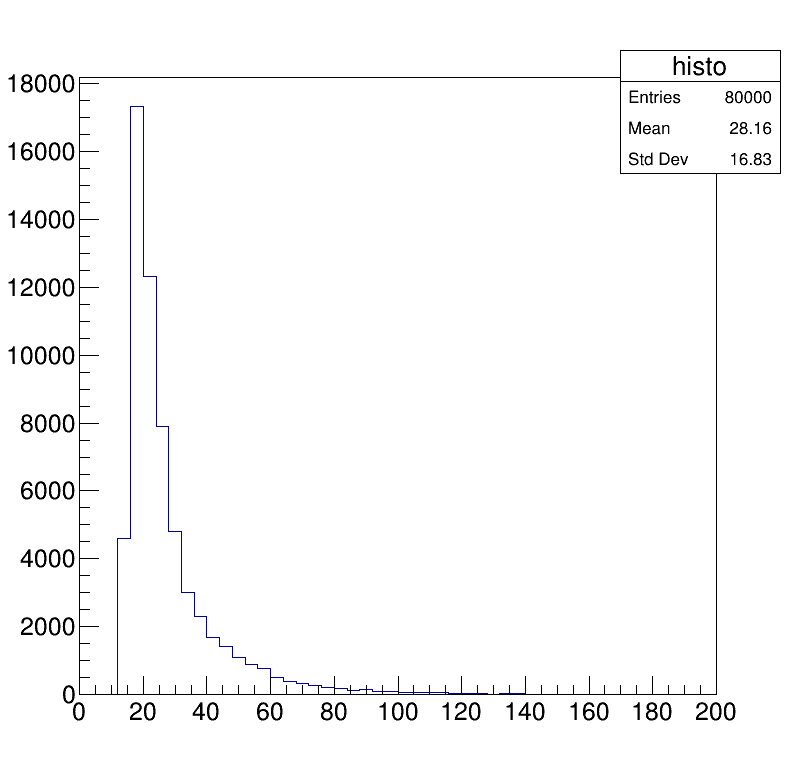

In [9]:
c = ROOT.TCanvas("", "", 800, 800)
h = subhisto.Clone()
h.Draw()
c.Draw()

### Filtering the number of jets in the category

In [10]:
new_df = df.Filter(
    # ask for a minimum number of jets (depending on the category)
    # with pt > 20 (+ sth depending on the dataset)
    "Jet_pt["
        "Jet_pt >= (20 + {0}) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
        "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
        "&& maskDeltaR("
            "Jet_eta, "
            "Jet_phi, "
            "lead_sublead_goodtau_eta, "
            "lead_sublead_goodtau_phi, "
            "0.5)"
        "].size() >= {1} "
    # ask for a maximum number of jets (depending on the category)
    # with pt > 20 (+ sth depending on the dataset)
    "&& Jet_pt["
        "Jet_pt >= (20 + {0}) && abs(Jet_eta) <= 4.7 && Jet_jetId >= 2 "
        "&& ((Jet_puId >= 4 && Jet_pt <= 50) || (Jet_pt > 50))"
        "&& maskDeltaR("
            "Jet_eta, "
            "Jet_phi, "
            "lead_sublead_goodtau_eta, "
            "lead_sublead_goodtau_phi, "
            "0.5)"
        "].size() <= {2}".format(
            ADD_TO_JETS,
            MIN_JETS,
            MAX_JETS,
        )
)

### Trigger requirements on the L1 Taus and Jets

In [11]:
name = "DoubleIsoTau32er2p1".format(xx)
new_df = new_df.Define(name, 
    "L1Obj_pt["
        "L1Obj_type == 1 "
        "&& abs(L1Obj_eta) <= 2.1 "
        "&& L1Obj_iso == 1 "
        "&& L1Obj_pt >= 32"
    "].size() >= 2"
)
name = "DoubleIsoTau{}er2p1".format(xx)
new_df = new_df.Define(name, 
    "L1Obj_pt["
        "L1Obj_type == 1 "
        "&& abs(L1Obj_eta) <= 2.1 "
        "&& L1Obj_iso == 1 "
        "&& L1Obj_pt >= {}"
    "].size() >= 2".format(xx)
)
name = "DoubleIsoTau{}er2p1Jet{}dR0p5".format(yy, zz)
new_df = new_df.Define(name,
    "lead_sublead_goodl1tau_pt[0] >= {0} "
    "&& lead_sublead_goodl1tau_pt[1] >= {0}"
    "&& lead_sublead_goodl1jet_pt[0] >= {1}".format(yy, zz))
name = "DoubleIsoTau{}er2p1Jet{}dR0p5Jet{}dR0p5".format(yy, zz1, zz2)
new_df = new_df.Define(name,
    "lead_sublead_goodl1tau_pt[0] >= {0} "
    "&& lead_sublead_goodl1tau_pt[1] >= {0}"
    "&& lead_sublead_goodl1jet_pt[0] >= {1}"
    "&& lead_sublead_goodl1jet_pt[1] >= {2}".format(yy, zz1, zz2))

### Trigger requirements on the Reco Taus and Jets

In [12]:
name = "RecoDoubleIsoTau{}er2p1".format(xx)
new_df = new_df.Define(name, 
    "lead_sublead_goodtau_pt[0] >= ({0} + {1}) "
    "&& lead_sublead_goodtau_pt[1] >= ({0} + {2})".format(
        xx, 
        ADD_TO_LEADING_TAU,
        ADD_TO_SUBLEADING_TAU,
    )
)
name = "RecoDoubleIsoTau{}er2p1".format(32)
new_df = new_df.Define(name, 
    "lead_sublead_goodtau_pt[0] >= ({0} + {1}) "
    "&& lead_sublead_goodtau_pt[1] >= ({0} + {2})".format(
        32, 
        ADD_TO_LEADING_TAU,
        ADD_TO_SUBLEADING_TAU,
    )
)
name = "RecoDoubleIsoTau{}er2p1Jet{}dR0p5".format(yy, zz)
new_df = new_df.Define(name,
    # ask that the two taus have pt greater than yy (+ sth depending on the dataset)
    "lead_sublead_goodtau_pt[0] >= ({0} + {1}) "
    "&& lead_sublead_goodtau_pt[1] >= ({0} + {2})"
    "&& lead_sublead_goodjet_pt[0] >= ({3} + {4})".format(
            yy, 
            ADD_TO_LEADING_TAU,
            ADD_TO_SUBLEADING_TAU,
            zz,
            ADD_TO_TRIGGER_JETS
        )
)
name = "RecoDoubleIsoTau{}er2p1Jet{}dR0p5Jet{}dR0p5".format(yy, zz1, zz2)
new_df = new_df.Define(name,
    # ask that the two taus have pt greater than yy (+ sth depending on the dataset)
    "lead_sublead_goodtau_pt[0] >= ({0} + {1}) "
    "&& lead_sublead_goodtau_pt[1] >= ({0} + {2})"
    "&& lead_sublead_goodjet_pt[0] >= ({3} + {5})"
    "&& lead_sublead_goodjet_pt[0] >= ({4} + {5})".format(
            yy, 
            ADD_TO_LEADING_TAU,
            ADD_TO_SUBLEADING_TAU,
            zz1,
            zz2,
            ADD_TO_TRIGGER_JETS
        )
)

In [13]:
hmodel = ("histo", "", 2, 0, 2)
histo32 = new_df.Define("pass", "DoubleIsoTau32er2p1").Histo1D(hmodel, "pass")
histoxx = new_df.Define("pass", "DoubleIsoTau34er2p1").Histo1D(hmodel, "pass")
histoReco32 = new_df.Define("pass", "RecoDoubleIsoTau32er2p1").Histo1D(hmodel, "pass")
histoRecoxx = new_df.Define("pass", "RecoDoubleIsoTau{}er2p1".format(xx)).Histo1D(hmodel, "pass")
histoAND32 = new_df.Define("pass", "DoubleIsoTau32er2p1 && RecoDoubleIsoTau32er2p1").Histo1D(hmodel, "pass")
histoANDxx = new_df.Define("pass", "DoubleIsoTau{0}er2p1 && RecoDoubleIsoTau{0}er2p1".format(xx)).Histo1D(hmodel, "pass")

histoyyzz = new_df.Define("pass", "DoubleIsoTau{}er2p1Jet{}dR0p5".format(yy, zz)).Histo1D(hmodel, "pass")
histoRecoyyzz = new_df.Define("pass", "RecoDoubleIsoTau{}er2p1Jet{}dR0p5".format(yy, zz)).Histo1D(hmodel, "pass")
histoANDyyzz = new_df.Define("pass", "DoubleIsoTau{0}er2p1Jet{1}dR0p5 && RecoDoubleIsoTau{0}er2p1Jet{1}dR0p5".format(yy, zz)).Histo1D(hmodel, "pass")

histoyyzz1zz2 = new_df.Define("pass", "DoubleIsoTau{}er2p1Jet{}dR0p5Jet{}dR0p5".format(yy, zz1, zz2)).Histo1D(hmodel, "pass")
histoRecoyyzz1zz2 = new_df.Define("pass", "RecoDoubleIsoTau{}er2p1Jet{}dR0p5Jet{}dR0p5".format(yy, zz1, zz2)).Histo1D(hmodel, "pass")
histoANDyyzz1zz2 = new_df.Define("pass", "DoubleIsoTau{0}er2p1Jet{1}dR0p5Jet{2}dR0p5 && RecoDoubleIsoTau{0}er2p1Jet{1}dR0p5Jet{2}dR0p5".format(yy, zz1, zz2)).Histo1D(hmodel, "pass")


histoORxxyyzz = new_df.Define("pass",
                              "(DoubleIsoTau{0}er2p1 && RecoDoubleIsoTau{0}er2p1)"
                              "|| (DoubleIsoTau{1}er2p1Jet{2}dR0p5 && RecoDoubleIsoTau{1}er2p1Jet{2}dR0p5)".format(xx, yy, zz)).Histo1D(hmodel, "pass")
histoORxxyyzz1zz2 = new_df.Define("pass",
                              "(DoubleIsoTau{0}er2p1 && RecoDoubleIsoTau{0}er2p1)"
                              "|| (DoubleIsoTau{1}er2p1Jet{2}dR0p5Jet{3}dR0p5 && RecoDoubleIsoTau{1}er2p1Jet{2}dR0p5Jet{3}dR0p5)".format(xx, yy, zz1, zz2)).Histo1D(hmodel, "pass")

## Using loops

### Functions needed to compute deltaR(tau, jet)

In [14]:
def Phi_mpi_pi(x):
    PI = 3.14159
    while x >= PI: x -= 2 * PI;
    while x < -PI: x += 2 * PI;
    return x;
def get_delta_r(eta1, phi1, eta2, phi2):
    import math
    deta = eta1 - eta2
    dphi = Phi_mpi_pi(phi1 - phi2)
    return math.sqrt(deta * deta + dphi * dphi)

### Actual loop

In [15]:
if DO_LOOPS:

    total_events = 0

    l1_events_xx = 0
    reco_events_xx = 0
    and_events_xx = 0

    l1_events_yy_zz = 0
    reco_events_yy_zz = 0
    and_events_yy_zz = 0

    or_events_xx_yy_zz = 0

    # for event in f.Events:  # to run on a TFile
    for event in f:  # to run on a TChain

        total_events += 1

        ### DoubleIsoTauXXer2p1

        # start storing the 4-vectors for the leading and subleading taus
        leading_l1_tau = [-1., -1., -1., -1.]
        subleading_l1_tau = [-1., -1., -1., -1.]
        for L1Obj in zip(event.L1Obj_pt, event.L1Obj_type, event.L1Obj_eta, event.L1Obj_phi, event.L1Obj_iso):
            if L1Obj[1] != 1: continue # skip if it's not a tau
            if abs(L1Obj[2]) > 2.1: continue # skip if the L1 tau doesn't pass the eta req
            if L1Obj[4] != 1: continue # skip if the L1 tau is not isolated

            if L1Obj[0] > leading_l1_tau[0]:
                subleading_l1_tau = [leading_l1_tau[0], leading_l1_tau[1], leading_l1_tau[2], leading_l1_tau[3]]
                leading_l1_tau = [L1Obj[0], L1Obj[2], L1Obj[3], L1Obj[0]]
            elif L1Obj[0] > subleading_l1_tau[0]:
                subleading_l1_tau = [L1Obj[0], L1Obj[2], L1Obj[3], L1Obj[0]]

        leading_tau = [-1., -1., -1., -1.]
        subleading_tau = [-1., -1., -1., -1.]
        for tau in zip(event.Tau_pt, event.Tau_eta, event.Tau_phi, event.Tau_mass):
            if abs(tau[1]) > 2.1: continue
            if tau[0] > leading_tau[0]:
                subleading_tau = [leading_tau[0], leading_tau[1], leading_tau[2], leading_tau[3]]
                leading_tau = [tau[0], tau[1], tau[2], tau[3]]
            elif tau[0] > subleading_tau[0]:
                subleading_tau = [tau[0], tau[1], tau[2], tau[3]]

        # with the leading and subleading taus we can already say if the event passes
        # the trigger reqs for L1, Reco and L1 AND Reco

        l1_xx = (leading_l1_tau[0] >= xx and subleading_l1_tau[0] >= xx)
        reco_xx = (leading_tau[0] >= xx + ADD_TO_LEADING_TAU and subleading_tau[0] >= xx + ADD_TO_SUBLEADING_TAU)

        ### DoubleIsoTauYYer2p1JetZZdR0p5

        # loop over the l1 jets
        triggerl1jets = 0
        jet_pts = []
        for L1Obj in zip(event.L1Obj_pt, event.L1Obj_type, event.L1Obj_eta, event.L1Obj_phi):
            if L1Obj[1] != 0: continue # skip if it's not a jet
            # require no matching between the jet and the selected taus
            if get_delta_r(L1Obj[2], L1Obj[3], leading_l1_tau[1], leading_l1_tau[2]) < 0.5: continue
            if get_delta_r(L1Obj[2], L1Obj[3], subleading_l1_tau[1], subleading_l1_tau[2]) < 0.5: continue

            if L1Obj[0] < zz: continue # skip if its pt is smaller than zz

            triggerl1jets += 1

        # loop over the reco jets
        eventjets = 0
        triggerjets = 0
        for jet in zip(event.Jet_pt, event.Jet_eta, event.Jet_phi, event.Jet_mass, event.Jet_puId, event.Jet_jetId):
            if abs(jet[1]) > 4.7: continue # eta requirement
            if jet[5] < 2: continue # id requirement
            if jet[0] <= 50 and jet[4] < 4: continue # PUiD requirement
            # require no matching between the jet and the selected taus
            if get_delta_r(jet[1], jet[2], leading_tau[1], leading_tau[2]) < 0.5: continue
            if get_delta_r(jet[1], jet[2], subleading_tau[1], subleading_tau[2]) < 0.5: continue
            if jet[0] >= zz + ADD_TO_TRIGGER_JETS:
                triggerjets += 1
            # count also the total jets in the event in order to categorize it
            if jet[0] >= 20 + ADD_TO_JETS:
                eventjets += 1

        l1_yy_zz = ((triggerl1jets >= 1) and (leading_l1_tau[0] >= yy) and (subleading_l1_tau[0] >= yy))
        reco_yy_zz = ((triggerjets >= 1)
            and (leading_tau[0] >= yy + ADD_TO_LEADING_TAU) and (subleading_tau[0] >= yy + ADD_TO_SUBLEADING_TAU))

        # categorization
        if eventjets < MIN_JETS or eventjets > MAX_JETS: continue # looking only at the 2 jet category

        # triggers that were passed
        l1_events_xx += l1_xx
        reco_events_xx += reco_xx
        and_events_xx += (l1_xx and reco_xx)

        l1_events_yy_zz += l1_yy_zz    
        reco_events_yy_zz += reco_yy_zz
        and_events_yy_zz += (l1_yy_zz and reco_yy_zz)

        or_events_xx_yy_zz += ((l1_xx and reco_xx) or (l1_yy_zz and reco_yy_zz))

## Summary

In [16]:
if DO_LOOPS: print "total_events", total_events
print
print "**** RDataFrame ****"
print "DoubleIsoTau{}, L1 {}".format(xx, histoxx.Clone().GetBinContent(2))
print "DoubleIsoTau{}, Reco {}".format(xx, histoRecoxx.Clone().GetBinContent(2))
print "DoubleIsoTau{}, AND {}".format(xx, histoANDxx.Clone().GetBinContent(2))
print
print "DoubleIsoTau{}Jet{}, L1 {}".format(yy, zz, histoyyzz.Clone().GetBinContent(2))
print "DoubleIsoTau{}Jet{}, Reco {}".format(yy, zz, histoRecoyyzz.Clone().GetBinContent(2))
print "DoubleIsoTau{}Jet{}, AND {}".format(yy, zz, histoANDyyzz.Clone().GetBinContent(2))
print
print "DoubleIsoTau{} OR DoubleIsoTau{}Jet{} {}".format(xx, yy, zz, histoORxxyyzz.Clone().GetBinContent(2))
print
print "DoubleIsoTau{}Jet{}Jet{}, L1 {}".format(yy, zz1, zz2, histoyyzz1zz2.Clone().GetBinContent(2))
print "DoubleIsoTau{}Jet{}Jet{}, Reco {}".format(yy, zz1, zz2, histoRecoyyzz1zz2.Clone().GetBinContent(2))
print "DoubleIsoTau{}Jet{}Jet{}, AND {}".format(yy, zz1, zz2, histoANDyyzz1zz2.Clone().GetBinContent(2))
print
print "DoubleIsoTau{} OR DoubleIsoTau{}Jet{}Jet{} {}".format(xx, yy, zz1, zz2, histoORxxyyzz1zz2.Clone().GetBinContent(2))
print
print "DoubleIsoTau32"
print "DoubleIsoTau32, L1", histo32.Clone().GetBinContent(2)
print "DoubleIsoTau32, Reco", histoReco32.Clone().GetBinContent(2)
print "DoubleIsoTau32, AND", histoAND32.Clone().GetBinContent(2)
print
print "(DoubleIsoTau{} OR DoubleIsoTau{}Jet{}) / DoubleIsoTau32 {}".format(xx, yy, zz, histoORxxyyzz.Clone().GetBinContent(2) / histoAND32.Clone().GetBinContent(2))
print
print "(DoubleIsoTau{} OR DoubleIsoTau{}Jet{}Jet{}) / DoubleIsoTau32 {}".format(xx, yy, zz1, zz2, histoORxxyyzz1zz2.Clone().GetBinContent(2) / histoAND32.Clone().GetBinContent(2))
print

if DO_LOOPS:
    print "**** LOOPS ****"
    print "l1_events_xx", l1_events_xx
    print "reco_events_xx", reco_events_xx
    print "and_events_xx", and_events_xx
    print
    print "l1_events_yy_zz", l1_events_yy_zz
    print "reco_events_yy_zz", reco_events_yy_zz
    print "and_events_yy_zz", and_events_yy_zz
    print
    print "or_events_xx_yy_zz", or_events_xx_yy_zz


total_events 80000

**** RDataFrame ****
DoubleIsoTau34, L1 2379.0
DoubleIsoTau34, Reco 448.0
DoubleIsoTau34, AND 330.0

DoubleIsoTau26Jet64, L1 716.0
DoubleIsoTau26Jet64, Reco 383.0
DoubleIsoTau26Jet64, AND 218.0

DoubleIsoTau34 OR DoubleIsoTau26Jet64 419.0

DoubleIsoTau26Jet64Jet64, L1 27.0
DoubleIsoTau26Jet64Jet64, Reco 383.0
DoubleIsoTau26Jet64Jet64, AND 9.0

DoubleIsoTau34 OR DoubleIsoTau26Jet64Jet64 332.0

DoubleIsoTau32
DoubleIsoTau32, L1 2891.0
DoubleIsoTau32, Reco 591.0
DoubleIsoTau32, AND 432.0

(DoubleIsoTau34 OR DoubleIsoTau26Jet64) / DoubleIsoTau32 0.969907407407

(DoubleIsoTau34 OR DoubleIsoTau26Jet64Jet64) / DoubleIsoTau32 0.768518518519

**** LOOPS ****
l1_events_xx 2379
reco_events_xx 448
and_events_xx 330

l1_events_yy_zz 717
reco_events_yy_zz 383
and_events_yy_zz 218

or_events_xx_yy_zz 419


# RATES

In [9]:
# Declare process and dataset objects
rate_process = Process("rate", "rate", color=(0, 0, 0))
ggf_bis = Dataset("rate",
             #"/eos/user/j/jleonhol/HH/ggf_2018_nanotest2/",
             #"/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/stempl/CRAB/EphemeralZeroBias8/zb_Nov2020-v2/201119_174913/0000/",
             "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/TEAshiftNtuples/ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1/ZeroBias",
             rate_process)

# build RDataFrame and open TFile to obtain the results using both methods
files = ggf_bis.get_files()
print files
dataframe_files = ROOT.vector(str)()
for f in files:
    dataframe_files.push_back(f)
df = ROOT.RDataFrame("l1EventTree/L1EventTree", dataframe_files)

['/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/TEAshiftNtuples/ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1/ZeroBias/crab_ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1__322079_ZeroBias_Run2018D-v1/180908_184351/0000/L1Ntuple_1.root', '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/TEAshiftNtuples/ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1/ZeroBias/crab_ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1__322079_ZeroBias_Run2018D-v1/180908_184351/0000/L1Ntuple_10.root', '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/TEAshiftNtuples/ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1/ZeroBias/crab_ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1__322079_ZeroBias_Run2018D-v1/180908_184351/0000/L1Ntuple_11.root', '/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/TEAshiftNtuples/ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10_2_1/ZeroBias/crab_ZeroBias2018D-week36-l1t-integration-v100p0-CMSSW-10

In [10]:
histo = df.Histo1D("run")

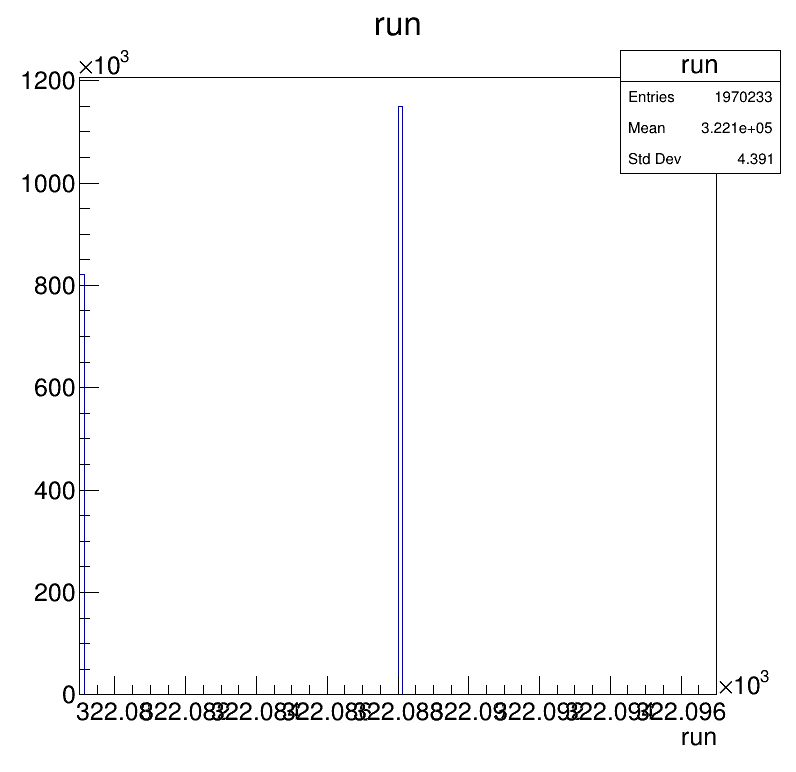

In [11]:
c = ROOT.TCanvas("", "", 800, 800)
histo.Draw()
c.Draw()

In [5]:
histo_lumi = df.Histo1D("lumi")

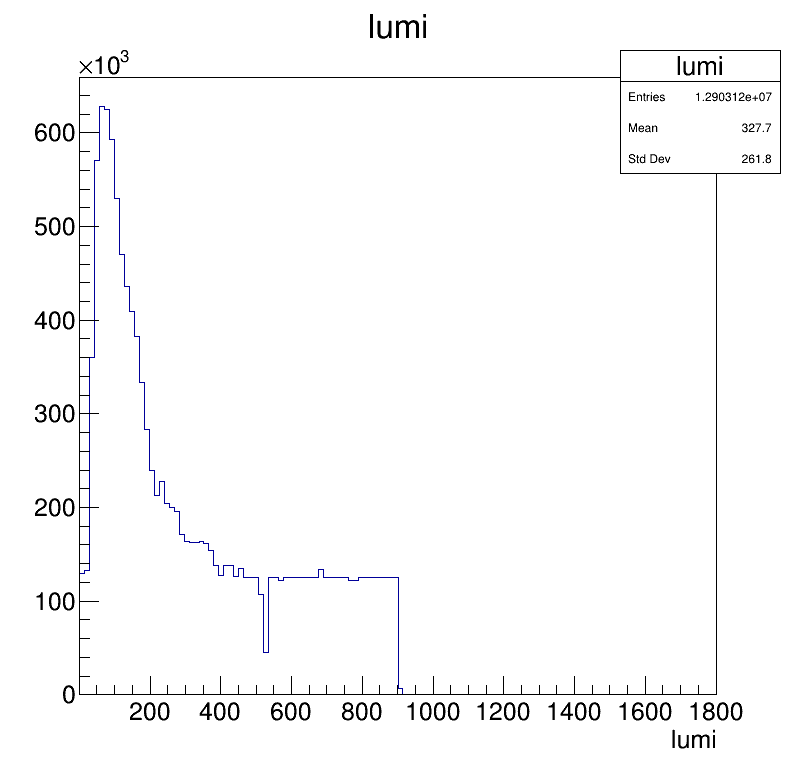

In [11]:
c = ROOT.TCanvas("", "", 800, 800)
histo_lumi.Draw()
c.Draw()

In [6]:
histo_orbit = df.Histo1D("orbit")

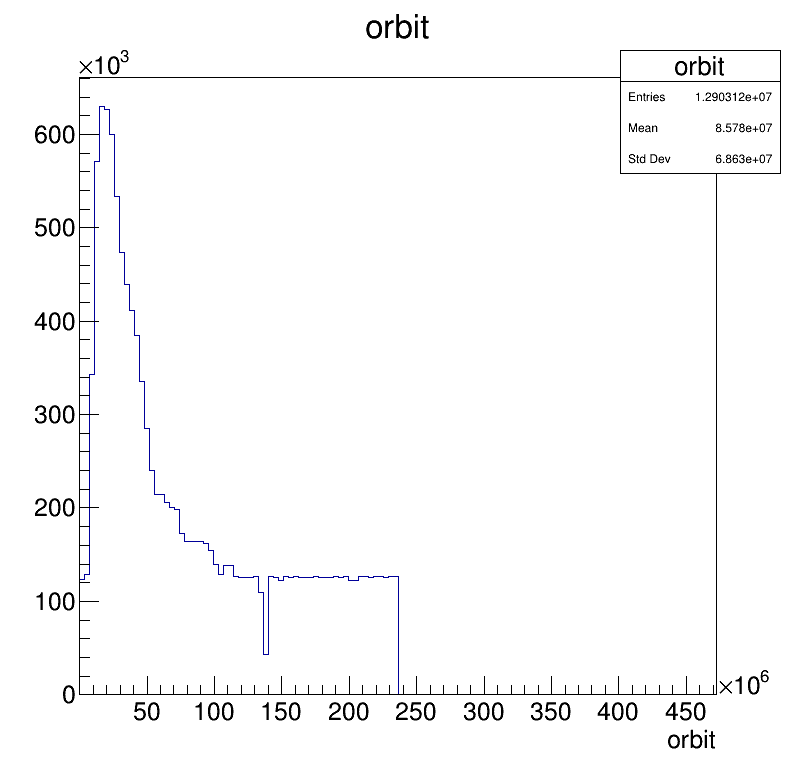

In [13]:
c = ROOT.TCanvas("", "", 800, 800)
histo_orbit.Draw()
c.Draw()